In [105]:
import warnings
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    r2_score,
    mean_squared_error,
    mean_squared_log_error,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
import requests
import time
from tqdm import tqdm


THe follwing is a Google drive link the Dataset.
It contains 2 csv files named
- tmdb_5000_movies.csv
- tmdb_5000_credits.csv


Link: https://drive.google.com/drive/folders/1sLJgRJqSn13nW4-RBRjIlrP9R-kZc27y?usp=sharing

In [106]:
# Load CSVs
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

# Merge on title
df = movies.merge(credits, on='title')

# Select relevant columns
df = df[['title', 'budget', 'revenue', 'release_date', 'runtime', 'genres', 'keywords',
         'original_language', 'popularity', 'vote_average', 'vote_count', 'overview', 'cast', 'crew']]

In [107]:
# Basic clean-up
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df = df[(df['budget'] > 0) & (df['revenue'] > 0)].reset_index(drop=True)
# Extract release year
df['release_year'] = df['release_date'].dt.year

In [108]:
# Extract director
def get_director(crew_str):
    try:
        crew = ast.literal_eval(crew_str)
        for person in crew:
            if person['job'] == 'Director':
                return person['name']
    except:
        return None
df['director'] = df['crew'].apply(get_director)


In [109]:
# Extract top 3 cast
def get_top_cast(cast_str, n=3):
    try:
        cast = ast.literal_eval(cast_str)
        return [person['name'] for person in cast[:n]]
    except:
        return []
df['cast_top3'] = df['cast'].apply(lambda x: get_top_cast(x))


In [110]:
# Genre count
df['genre_count'] = df['genres'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)

# Keyword count
df['keyword_count'] = df['keywords'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)

# Profit column
df['profit'] = df['revenue'] - df['budget']

Enrich with IMDB Data via OMDB API

In [111]:
# Replace with your key
OMDB_API_KEY = '56e6059c'

In [112]:
def fetch_omdb_data(title, year, api_key=OMDB_API_KEY):
    try:
        url = f"http://www.omdbapi.com/?t={title}&y={year}&apikey={api_key}"
        response = requests.get(url)
        data = response.json()

        if data.get('Response') == 'True':
            return {
                'imdb_rating': float(data.get('imdbRating', 0)),
                'imdb_votes': int(data.get('imdbVotes', '0').replace(',', '')),
                'metascore': int(data.get('Metascore', 0)) if data.get('Metascore') != 'N/A' else None,
                'rated': data.get('Rated'),
                'genre_omdb': data.get('Genre'),
                'runtime_omdb': data.get('Runtime'),
            }
        else:
            return {
                'imdb_rating': None,
                'imdb_votes': None,
                'metascore': None,
                'rated': None,
                'genre_omdb': None,
                'runtime_omdb': None
            }
    except Exception as e:
        print(f"Error for {title}: {e}")

In [113]:
# This is a test case
result = fetch_omdb_data("Inception", 2010)
print(result)


{'imdb_rating': 8.8, 'imdb_votes': 2671882, 'metascore': 74, 'rated': 'PG-13', 'genre_omdb': 'Action, Adventure, Sci-Fi', 'runtime_omdb': '148 min'}


In [114]:
TMDB_API_KEY = "931dea1b0e4175ea519f2d9235fd4b58"

def get_tmdb_id(title, year):
    try:
        url = f"https://api.themoviedb.org/3/search/movie?api_key={TMDB_API_KEY}&query={title}&year={year}"
        response = requests.get(url)
        data = response.json()
        if data['results']:
            return data['results'][0]['id']
    except:
        return None

def get_imdb_id(tmdb_id):
    try:
        url = f"https://api.themoviedb.org/3/movie/{tmdb_id}/external_ids?api_key={TMDB_API_KEY}"
        response = requests.get(url)
        data = response.json()
        return data.get('imdb_id')
    except:
        return None


Getting IMDB Rating,votes and meta score

In [115]:
# Create columns
df['imdb_rating'] = None
df['imdb_votes'] = None
df['metascore'] = None

for idx, row in df.iterrows():
    title = row['title']
    year = row['release_year']
    result = fetch_omdb_data(title, year)
    if result:
        df.at[idx, 'imdb_rating'] = result['imdb_rating']
        df.at[idx, 'imdb_votes'] = result['imdb_votes']
        df.at[idx, 'metascore'] = result['metascore']
    time.sleep(0.01)

Error for D-Tox: could not convert string to float: 'N/A'
Error for Julie & Julia: could not convert string to float: 'N/A'


In [116]:
df['tmdb_id']=None
df['imdb_id']=None
# Loop through and enrich


for i, row in tqdm(df.iterrows(), total=len(df)):
    tmdb_id = get_tmdb_id(row['title'], row['release_year'])
    imdb_id = get_imdb_id(tmdb_id) if tmdb_id else None

    df.at[i, 'tmdb_id'] = tmdb_id
    df.at[i, 'imdb_id'] = imdb_id


100%|██████████| 3232/3232 [08:58<00:00,  6.00it/s]


In [117]:
df[['title', 'budget', 'revenue', 'imdb_rating', 'imdb_votes', 'release_year']].head(10)


,title,budget,revenue,imdb_rating,imdb_votes,release_year
0,Avatar,237000000,2787965087,8,1428047,2009
1,Pirates of the Caribbean: At World's End,300000000,961000000,7,717220,2007
2,Spectre,245000000,880674609,7,478737,2015
3,The Dark Knight Rises,250000000,1084939099,8,1900637,2012
4,John Carter,260000000,284139100,None,None,2012
5,Spider-Man 3,258000000,890871626,6,666299,2007
6,Tangled,260000000,591794936,8,513682,2010
7,Avengers: Age of Ultron,280000000,1405403694,7,949059,2015
8,Harry Potter and the Half-Blood Prince,250000000,933959197,8,616702,2009
9,Batman v Superman: Dawn of Justice,250000000,873260194,6,769911,2016


Classifying the movies into HIT,FLOP,CLASSIC

In [118]:
def classify_movie(row):
    is_hit = row['revenue'] >= 2 * row['budget']
    is_flop = row['revenue'] < row['budget']
    # Safely extract with defaults
    rating = row.get('imdb_rating') or 0
    votes = row.get('imdb_votes') or 0
    year = row.get('release_year') or 3000
    metascore = row.get('metascore') or 0
    genres = str(row.get('genres', '')).lower()
    title = row.get('title', '')

    # Conditions for classic
    high_imdb = rating >= 8.0 and votes >= 100000
    old_and_gained = year <= 2010 and votes >= 250000
    critic_loved = metascore and metascore >= 75
    is_documentary = 'documentary' in genres
    cult_classics_list = [
        "Fight Club", "The Shawshank Redemption", "Donnie Darko", "The Big Lebowski",
        "Blade Runner", "Clerks", "Eternal Sunshine of the Spotless Mind", "Trainspotting"
    ]

    # Label logic
    if title in cult_classics_list:
        return 'Classic'
    elif is_hit:
        return 'Hit'
    elif is_flop:
        if high_imdb or old_and_gained or critic_loved or is_documentary:
            return 'Classic'
        else:
            return 'Flop'
    else:
        return 'Flop'


In [119]:
df['label'] = df.apply(classify_movie, axis=1)

In [120]:
# just checking if it works this is a same of the first 5
df[['title', 'budget', 'revenue', 'imdb_rating', 'imdb_votes', 'release_year', 'label']].head(5)


,title,budget,revenue,imdb_rating,imdb_votes,release_year,label
0,Avatar,237000000,2787965087,8,1428047,2009,Hit
1,Pirates of the Caribbean: At World's End,300000000,961000000,7,717220,2007,Hit
2,Spectre,245000000,880674609,7,478737,2015,Hit
3,The Dark Knight Rises,250000000,1084939099,8,1900637,2012,Hit
4,John Carter,260000000,284139100,None,None,2012,Flop


In [121]:
# Calculating classic score safely
def classic_score(row):
    score = 0
    if row.get('imdb_rating') is not None and row['imdb_rating'] >= 8.0:
        score += 1
    if row.get('imdb_votes') is not None and row['imdb_votes'] >= 200000:
        score += 1
    if row.get('release_year') is not None and row['release_year'] <= 2010:
        score += 1
    if row.get('metascore') is not None and row['metascore'] >= 75:
        score += 1
    if isinstance(row.get('genres'), str) and 'documentary' in row['genres'].lower():
        score += 1
    if row.get('title') in [
        "Fight Club", "The Shawshank Redemption", "Donnie Darko",
        "The Big Lebowski", "Blade Runner", "Clerks",
        "Eternal Sunshine of the Spotless Mind", "Trainspotting"
    ]:
        score += 2  # Bonus for known cult classics
    return score


In [122]:
df['classic_score'] = df.apply(classic_score, axis=1)


In [123]:
# a testcase to check if the classic score works
df[['title', 'budget', 'revenue', 'imdb_rating', 'imdb_votes', 'release_year', 'metascore', 'label', 'classic_score']].sort_values(by='classic_score', ascending=False).head(5)


,title,budget,revenue,imdb_rating,imdb_votes,release_year,metascore,label,classic_score
636,Fight Club,63000000,100853753,9,2456010,1999,67,Classic,5
325,The Lord of the Rings: The Two Towers,79000000,926287400,9,1859452,2002,87,Hit,4
476,The Lion King,45000000,788241776,8,1199828,1994,88,Hit,4
605,Saving Private Ryan,70000000,481840909,9,1558717,1998,91,Hit,4
766,Forrest Gump,55000000,677945399,9,2368927,1994,82,Hit,4


In [124]:
# Director popularity (based on frequency in dataset)
df['director_popularity'] = df['director'].map(df['director'].value_counts())

# Cast popularity – flatten all cast members into one list
all_cast = sum(df['cast_top3'], [])  # cast_top3 is a list of top 3 actors
cast_counts = Counter(all_cast)

# Take average popularity score of top 3 cast
df['cast_popularity'] = df['cast_top3'].apply(lambda cast: sum(cast_counts.get(c, 0) for c in cast) / len(cast) if cast else 0)


In [125]:
print(f"Total number of rows in df: {df.shape[0]}")


Total number of rows in df: 3232


In [126]:
# Extracting IMDB rating Data alone

subset = df[df['imdb_rating'].isna()].copy()

for idx, row in tqdm(subset.iterrows(), total=len(subset)):
    title = row['title']
    year = row['release_year']

    tmdb_id = get_tmdb_id(title, year)
    imdb_id = get_imdb_id(tmdb_id)
    omdb_data = fetch_omdb_data(imdb_id, year)

    subset.at[idx, 'tmdb_id'] = tmdb_id
    subset.at[idx, 'imdb_id'] = imdb_id

    if omdb_data:
        subset.at[idx, 'imdb_rating'] = omdb_data['imdb_rating']
        subset.at[idx, 'imdb_votes'] = omdb_data['imdb_votes']
        subset.at[idx, 'metascore'] = omdb_data['metascore']

    if idx % 500 == 0 and idx > 0:
        subset.iloc[:idx].to_csv(f"checkpoint_{idx}.csv", index=False)

    time.sleep(0.01)


100%|██████████| 1823/1823 [08:02<00:00,  3.77it/s]


In [127]:
df = df[df['imdb_rating'].notna()]  # Keep only previously enriched
df = pd.concat([df, subset], ignore_index=True)


In [128]:
# check if any values are still missing
df.isnull().sum()

title                     0
budget                    0
revenue                   0
release_date              0
runtime                   0
genres                    0
keywords                  0
original_language         0
popularity                0
vote_average              0
vote_count                0
overview                  0
cast                      0
crew                      0
release_year              0
director                  2
cast_top3                 0
genre_count               0
keyword_count             0
profit                    0
imdb_rating            1823
imdb_votes             1823
metascore              1852
tmdb_id                   4
imdb_id                   4
label                     0
classic_score             0
director_popularity       2
cast_popularity           0
dtype: int64

In [129]:
# Filling the missing Values
df['imdb_rating'] = df['imdb_rating'].fillna(df['vote_average'])
df['imdb_votes'] = df['imdb_votes'].fillna(df['vote_count']).astype('int')
df['director'] = df['director'].fillna('Unknown')
df['director_popularity'] = df['director_popularity'].fillna(0)
df['tmdb_id'] = df['tmdb_id'].fillna("tmdb_unknown")
df['imdb_id'] = df['imdb_id'].fillna("imdb_unknown")


C:\Users\surya\AppData\Local\Temp\ipykernel_22260\3589883558.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['imdb_rating'] = df['imdb_rating'].fillna(df['vote_average'])
C:\Users\surya\AppData\Local\Temp\ipykernel_22260\3589883558.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['imdb_votes'] = df['imdb_votes'].fillna(df['vote_count']).astype('int')


In [130]:
df['metascore'] = df.groupby('label')['metascore'].transform(
    lambda group: group.fillna(group.mean())
)


C:\Users\surya\AppData\Local\Temp\ipykernel_22260\3369784997.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda group: group.fillna(group.mean())


In [131]:
# check if any values are still missing
df.isnull().sum()

title                  0
budget                 0
revenue                0
release_date           0
runtime                0
genres                 0
keywords               0
original_language      0
popularity             0
vote_average           0
vote_count             0
overview               0
cast                   0
crew                   0
release_year           0
director               0
cast_top3              0
genre_count            0
keyword_count          0
profit                 0
imdb_rating            0
imdb_votes             0
metascore              0
tmdb_id                0
imdb_id                0
label                  0
classic_score          0
director_popularity    0
cast_popularity        0
dtype: int64

In [132]:
# The dataset is ready Here
df.to_csv("final_enriched_movies_dataset.csv", index=False)


# Exploratory Data Analysis

In [133]:
df=pd.read_csv('final_enriched_movies_dataset.csv')

In [133]:
# Sets the Graph background
sns.set(style='whitegrid', palette='pastel')
%matplotlib inline

Distribution based on the Label of the Movie

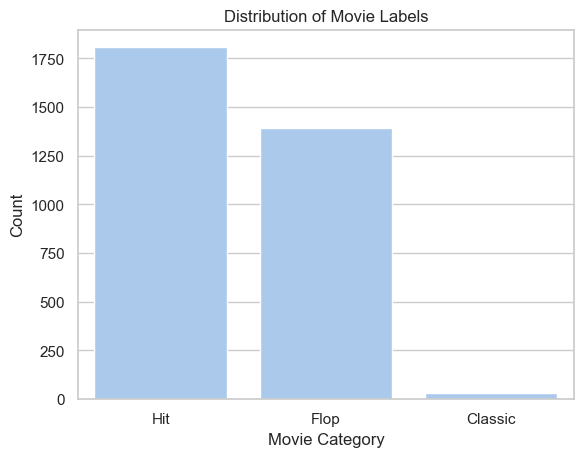

In [134]:
# Plot Label Distribution
sns.countplot(x='label', data=df)
plt.title("Distribution of Movie Labels")
plt.xlabel("Movie Category")
plt.ylabel("Count")
plt.show()


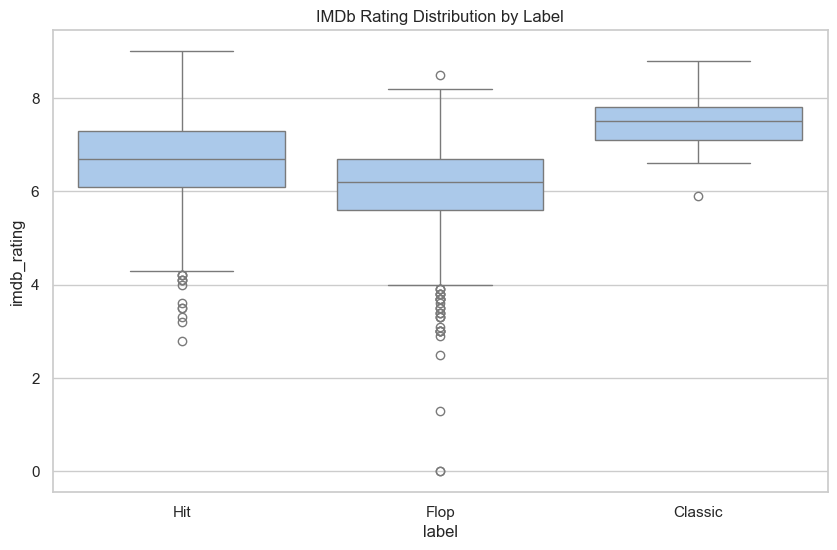

In [135]:
#Boxplots by Label
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='imdb_rating', data=df)
plt.title("IMDb Rating Distribution by Label")
plt.show()


Analysis on the Features

<Figure size 1200x800 with 0 Axes>

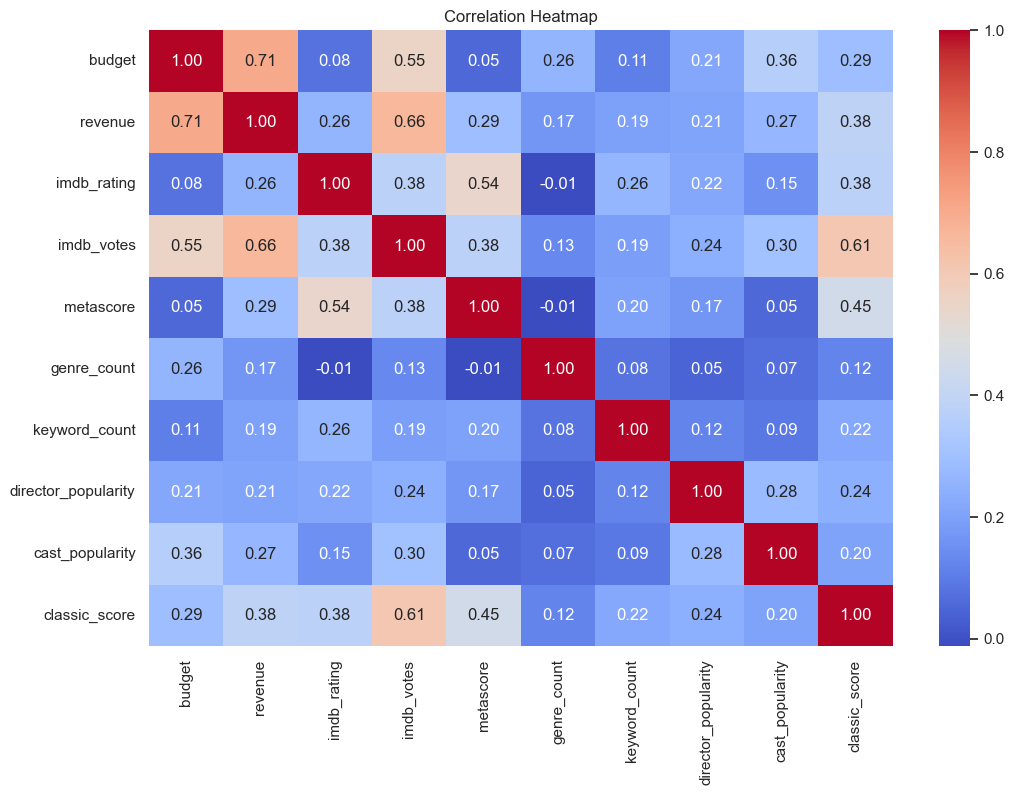

In [136]:
#Correlation Heatmap (Numerical Features)
plt.figure(figsize=(12, 8))
numerical_cols = [
    'budget', 'revenue', 'imdb_rating', 'imdb_votes', 'metascore',
    'genre_count', 'keyword_count', 'director_popularity', 'cast_popularity',
    'classic_score'  # Removed 'release_month'
]

plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


More budget → more revenue (as expected 💸). Highly rated by users → also loved by critics. Popular films tend to have better ratings. Widely viewed films earn more.
budget	imdb_rating	-0.00 Bigger budget ≠ better movie in audience eyes.
classic_score	Anything	< 0.1	"Classics" are not defined by popular traits — they’re ✨special✨
cast_popularity	revenue	0.27	Modest correlation: star power helps, but isn’t everything


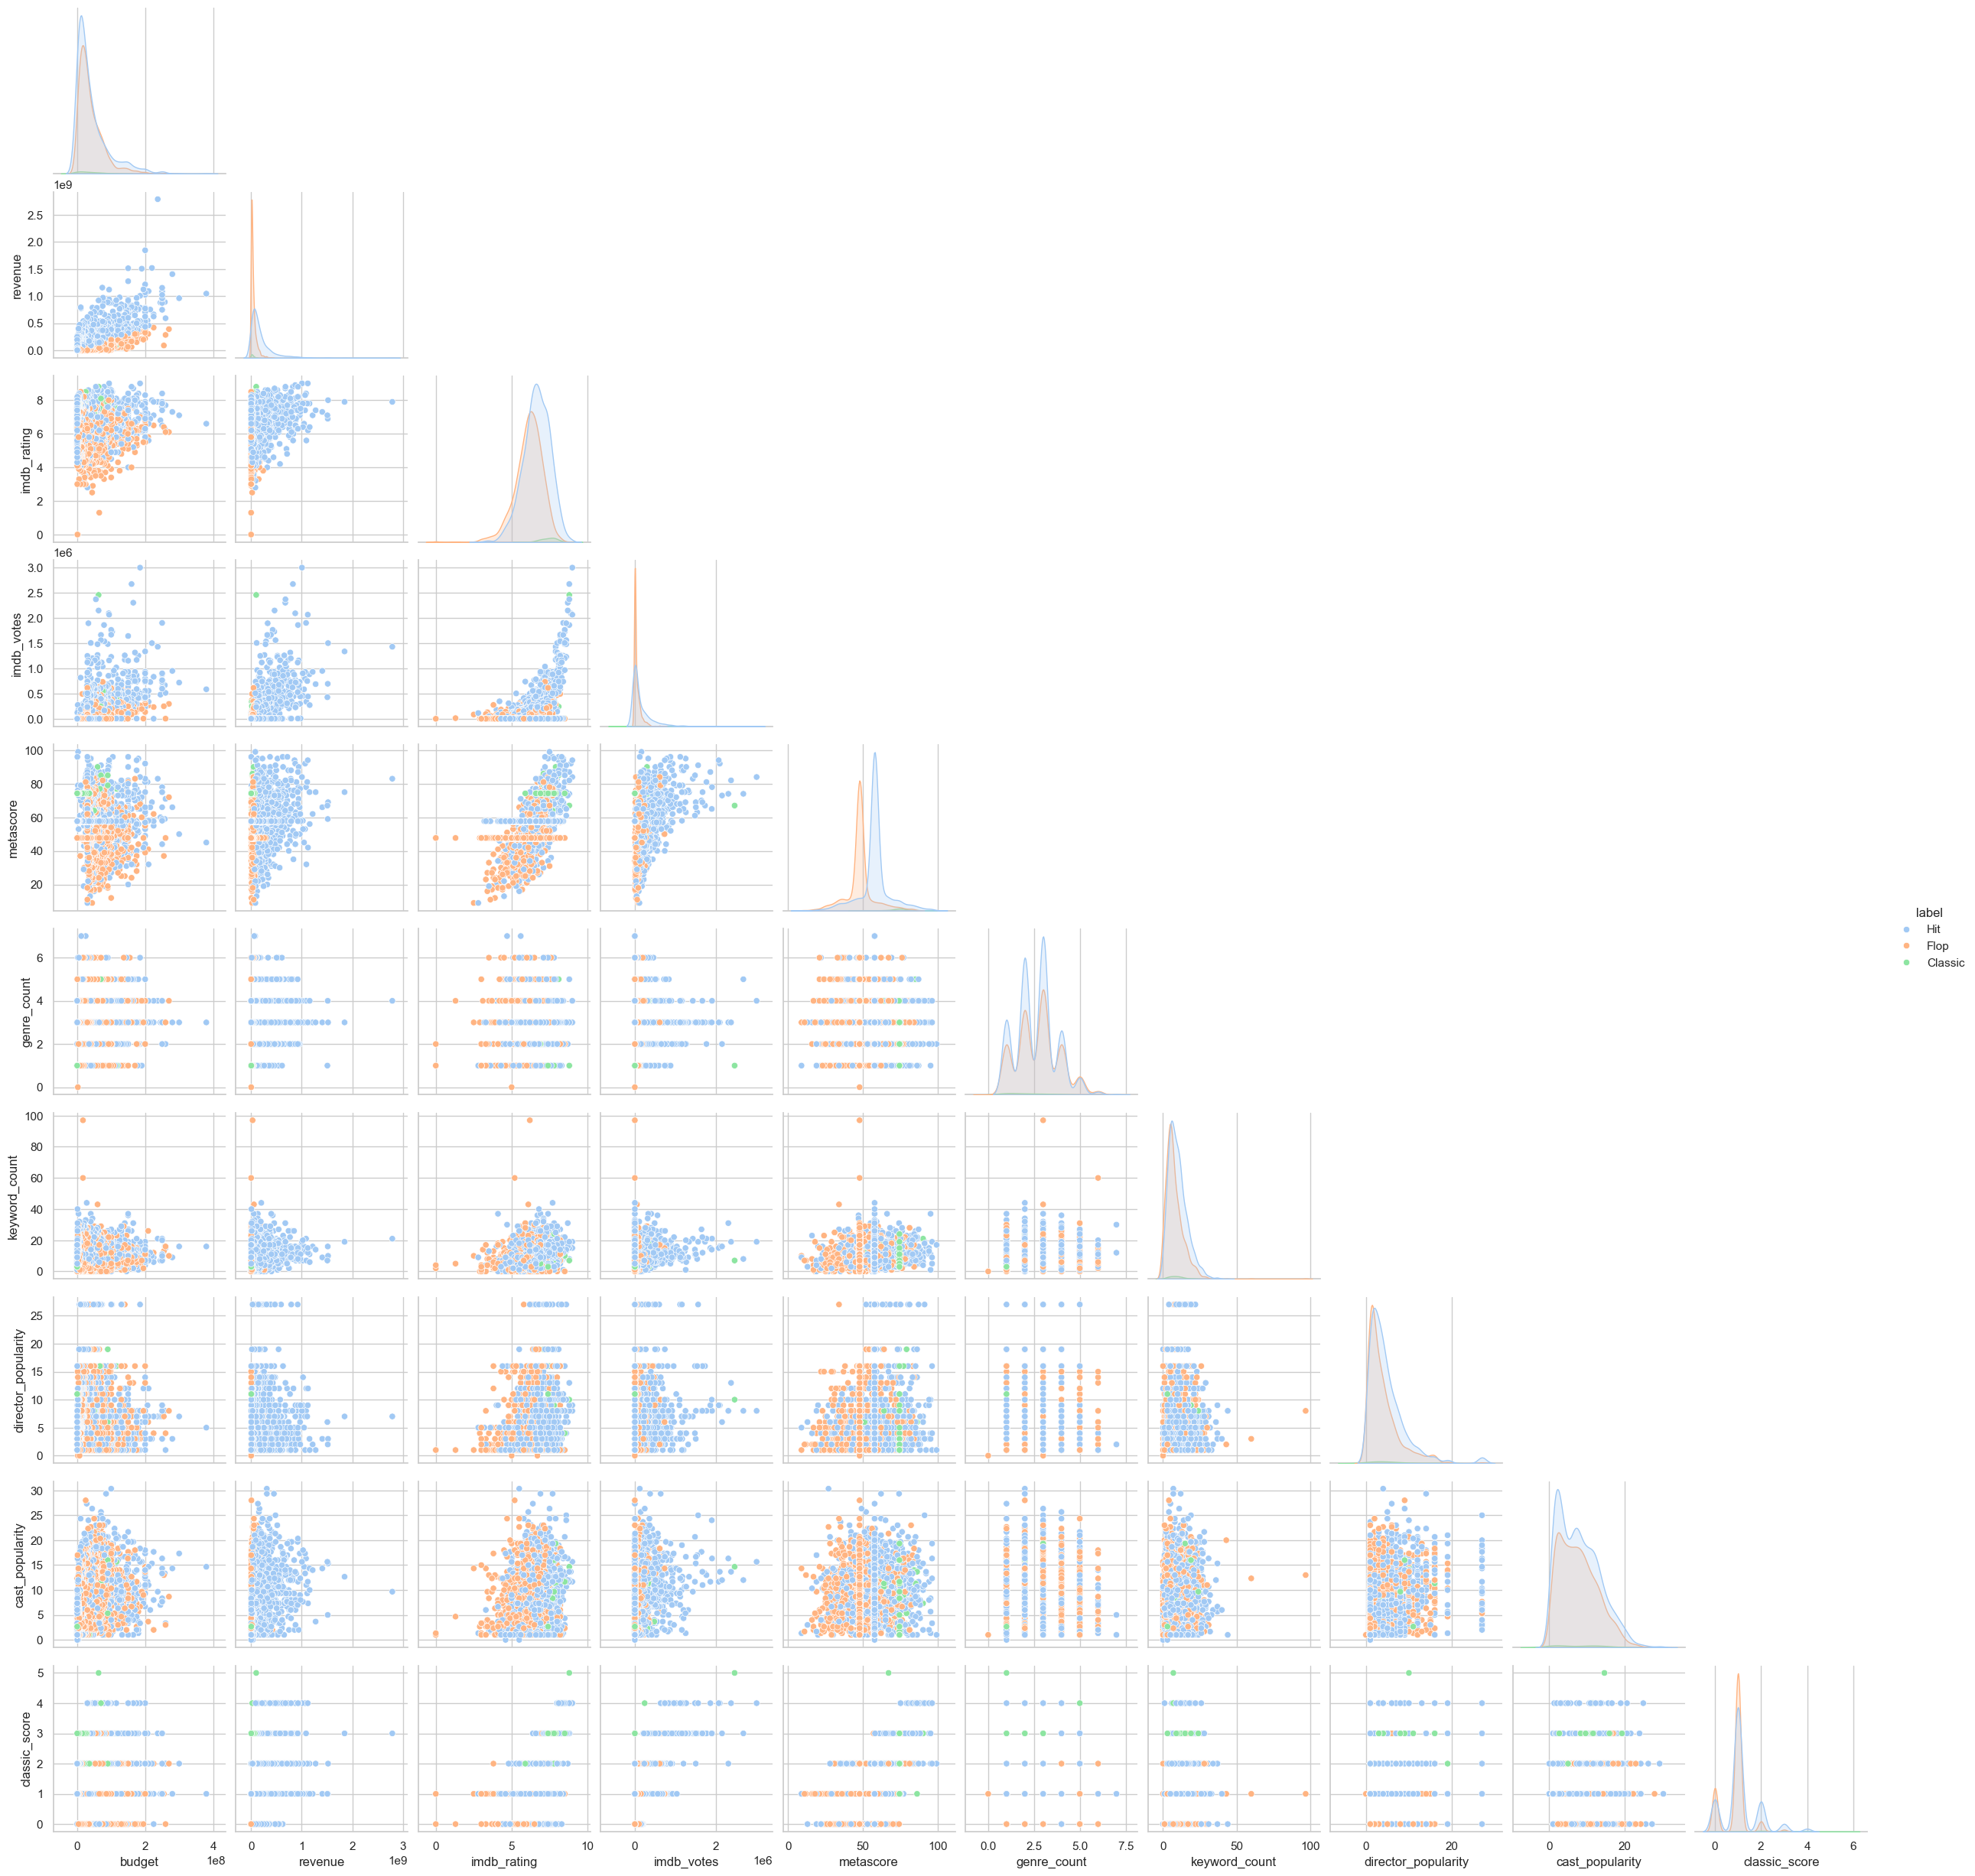

In [137]:
#Pair Plot - To see how labels spread across 2D plots
sns.pairplot(df[numerical_cols + ['label']], hue='label', corner=True)


✅ Cluster Patterns:

Hits (blue) dominate high revenue + high budget zones
Classics (green) cluster around high imdb_rating, metascore, but NOT revenue — that's expected! Cult classics often flop at the box office.
Flops (orange) span wide on budget, often with low ratings and votes

📌 Features with Visible Separation:

imdb_rating
metascore
revenue
budget
imdb_votes
These are your strong candidates for classification input features.



Analysis Based on Genre

In [138]:
# Parse the genres column
def parse_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [genre['name'] for genre in genres]
    except Exception:
        return []

df['parsed_genres'] = df['genres'].apply(parse_genres)

# Explode genres to count frequency
genre_series = df['parsed_genres'].explode()

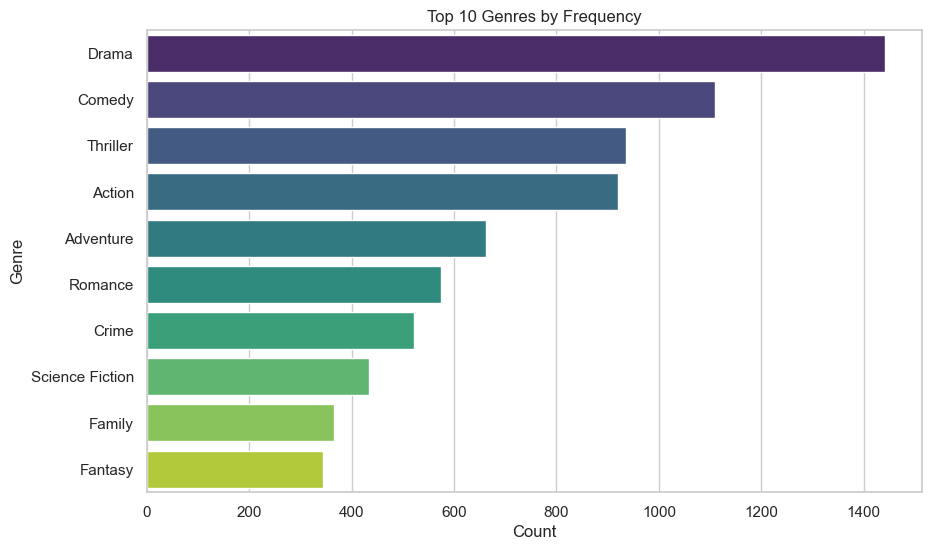

In [139]:
# Plot 1: Top 10 Genres by Frequency
plt.figure(figsize=(10, 6))
top_genres = genre_series.value_counts().head(10)

sns.barplot(
    x=top_genres.values,
    y=top_genres.index,
    hue=top_genres.index,        # Explicit hue assignment
    palette="viridis",
    legend=False                 # No legend needed
)

plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Frequency')
plt.show()


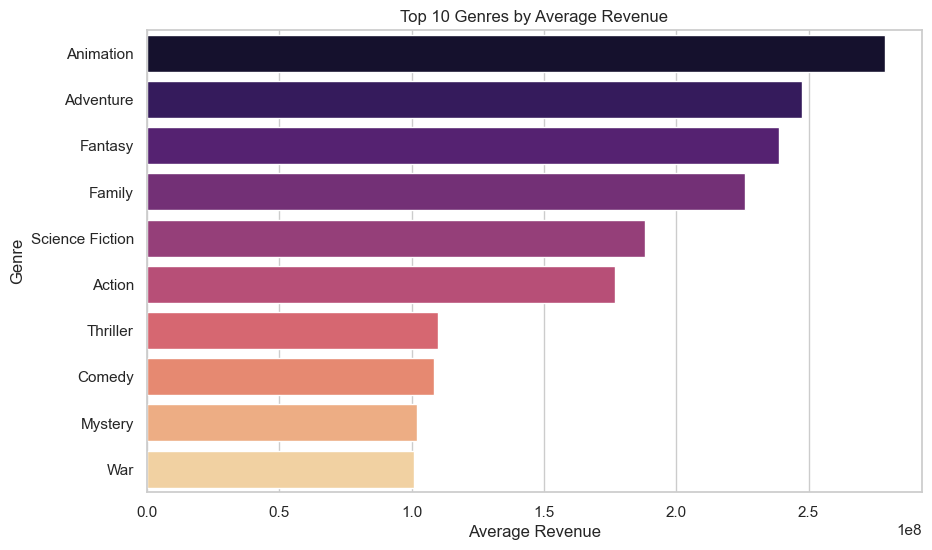

In [140]:
# Plot 2: Average Revenue by Genre (Top 10)
genre_revenue = df.explode('parsed_genres').groupby('parsed_genres')['revenue'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
top_genre_revenue = genre_revenue.head(10)
sns.barplot(x=top_genre_revenue.values, y=top_genre_revenue.index, hue=top_genre_revenue.index, palette="magma", legend=False)
plt.title("Top 10 Genres by Average Revenue")
plt.xlabel("Average Revenue")
plt.ylabel("Genre")
plt.show()


Genre Frequency
Most common: Drama, Comedy, Thriller

Tells you what genres are frequently produced (safe bets?)

Genre by Avg Revenue
Most profitable: Animation, Adventure, Fantasy, Family

These are high-budget, family-friendly blockbusters — usually studio-backed



Analysis Based on the Cast

In [141]:
# Parse the cast column
def parse_cast(cast_str):
    try:
        cast_list = ast.literal_eval(cast_str)
        return [c['name'] for c in cast_list[:3]]  # Top 3 actors only
    except Exception:
        return []

df['parsed_cast'] = df['cast'].apply(parse_cast)
# Explode to count frequency
actor_series = df['parsed_cast'].explode()


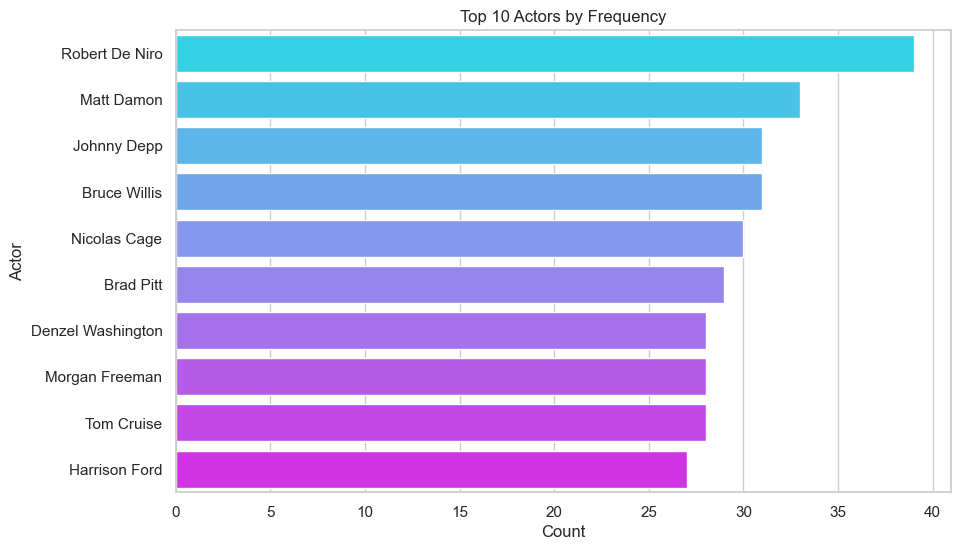

In [142]:
# Plot 1: Top 10 Actors by Frequency
plt.figure(figsize=(10, 6))
top_actors = actor_series.value_counts().head(10)

sns.barplot(
    x=top_actors.values,
    y=top_actors.index,
    hue=top_actors.index,
    palette="cool",
    legend=False
)

plt.xlabel('Count')
plt.ylabel('Actor')
plt.title('Top 10 Actors by Frequency')
plt.show()

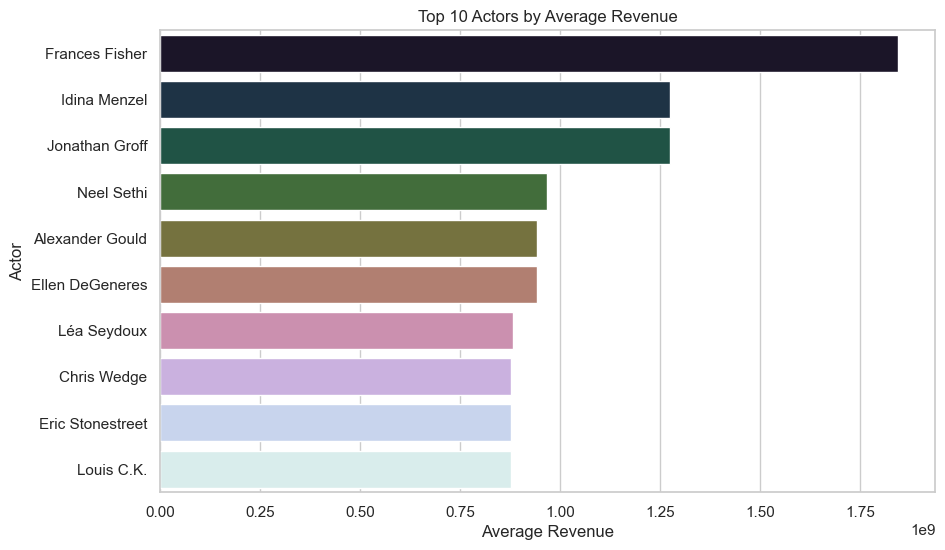

In [143]:
# Plot 2: Average Revenue by Actor (Top 10)
actor_revenue = df.explode('parsed_cast').groupby('parsed_cast')['revenue'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
top_actor_revenue = actor_revenue.head(10)

sns.barplot(
    x=top_actor_revenue.values,
    y=top_actor_revenue.index,
    hue=top_actor_revenue.index,
    palette="cubehelix",
    legend=False
)

plt.xlabel('Average Revenue')
plt.ylabel('Actor')
plt.title('Top 10 Actors by Average Revenue')
plt.show()

Top Actors by Frequency
Heavy-hitters like De Niro, Matt Damon, Tom Cruise

You now know who dominates the dataset and can add binary features accordingly

Actors by Avg Revenue
Frances Fisher, Idina Menzel, Ellen DeGeneres = strong in voiceover-heavy animation

Notice how frequent actors ≠ most profitable — goldmine insight for modeling 🎯



In [144]:
# Top 10 profitable genres
profitable_genres = ['Animation', 'Adventure', 'Fantasy', 'Family', 'Science Fiction']

df['is_profitable_genre'] = df['parsed_genres'].apply(
    lambda genres: any(g in profitable_genres for g in genres)
)

# Top 10 most frequent actors
top_actors = ['Robert De Niro', 'Matt Damon', 'Johnny Depp', 'Bruce Willis', 'Nicolas Cage',
              'Brad Pitt', 'Morgan Freeman', 'Tom Cruise', 'Denzel Washington', 'Ben Stiller']

df['has_top_actor'] = df['parsed_cast'].apply(
    lambda cast: any(actor in top_actors for actor in cast)
)

# Add number of genres and cast size
df['num_genres'] = df['parsed_genres'].apply(len)
df['num_top_cast'] = df['parsed_cast'].apply(
    lambda cast: sum(actor in top_actors for actor in cast)
)


Analysis on Budget and Revenue

In [145]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

yearly_data = df.groupby('release_year').agg({
    'budget': 'mean',
    'revenue': 'mean',
    'popularity': 'mean',
    'vote_average': 'mean'
}).reset_index()

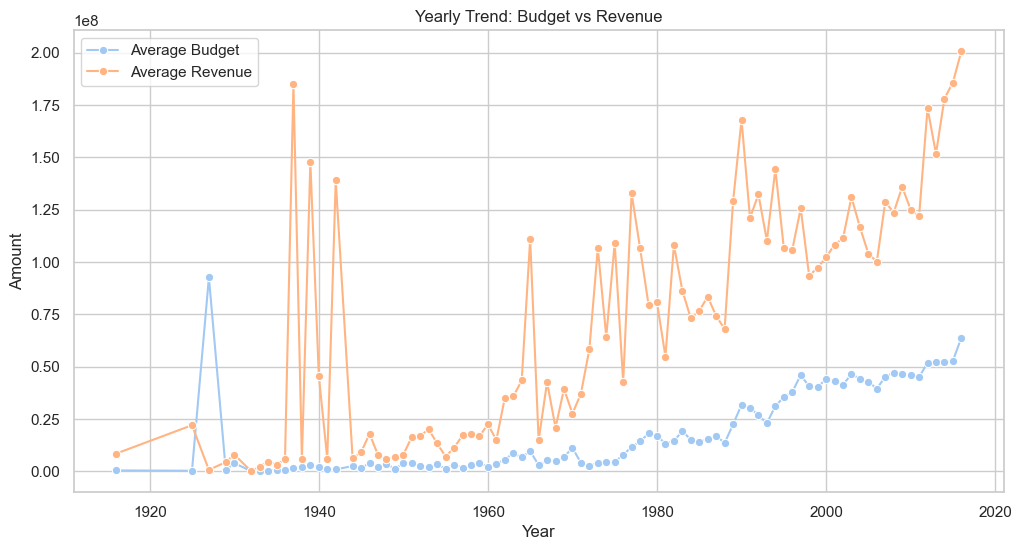

In [146]:

# Plot: Budget & Revenue Trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='budget', data=yearly_data, label='Average Budget', marker='o')
sns.lineplot(x='release_year', y='revenue', data=yearly_data, label='Average Revenue', marker='o')
plt.title("Yearly Trend: Budget vs Revenue")
plt.xlabel("Year")
plt.ylabel("Amount")
plt.legend()
plt.show()

Analysis on popularity based on the year of release

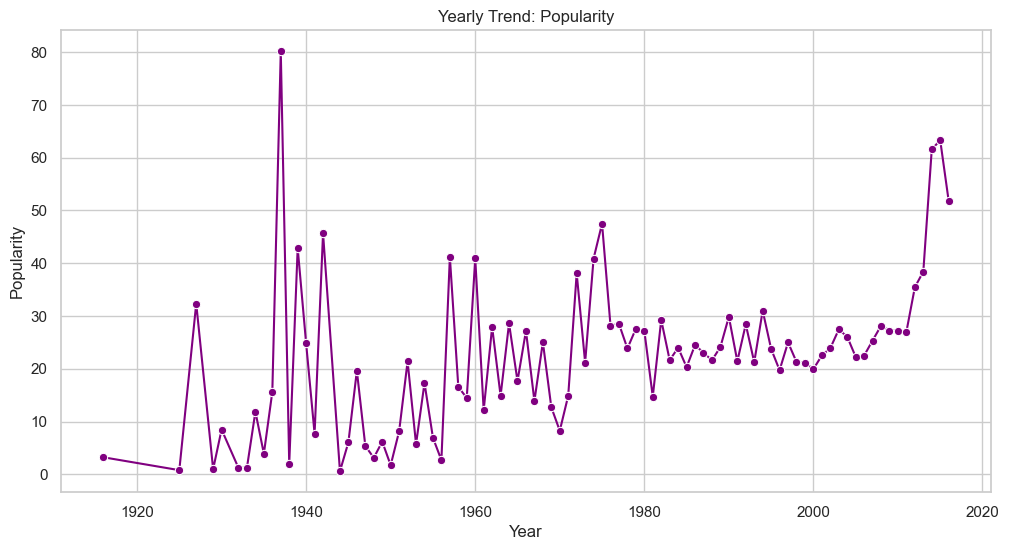

In [147]:
# Plot: Popularity Trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='popularity', data=yearly_data, color='purple', marker='o')
plt.title("Yearly Trend: Popularity")
plt.xlabel("Year")
plt.ylabel("Popularity")
plt.show()


**Demographic Filtering (IMDb-style Weighted Rating)**

1. Mimics IMDb’s Bayesian-style scoring. Weighs a movie's own rating (R) and vote count (v) Combines it with the overall average rating (C) Gives less importance to ratings with low votes (makes it more robust) python Copy Edit
2. Shows hidden gems — high-rated movies that are actually well-liked.
3. Can help identify or validate “Classic” status via vote-weighted logic.




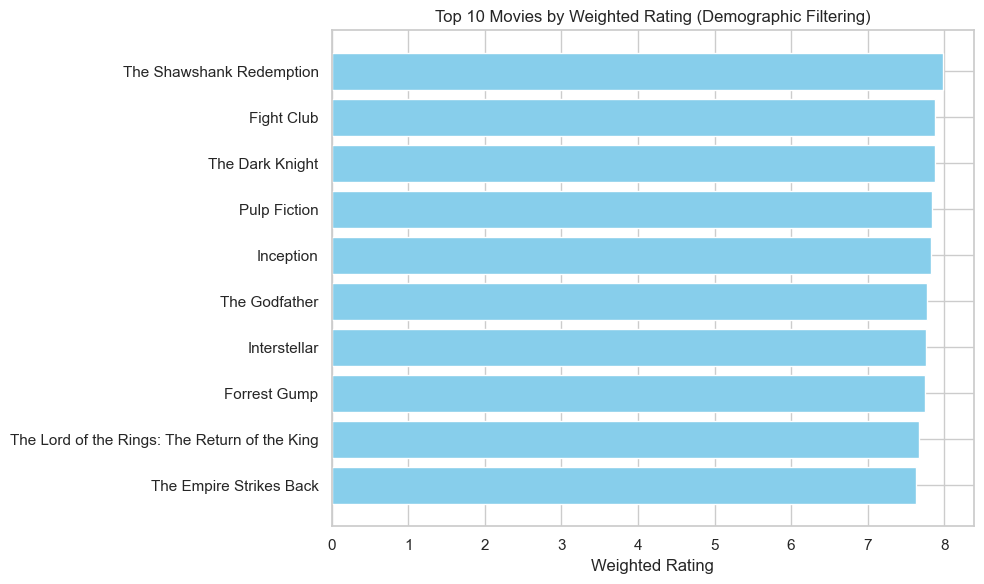

In [148]:
# Calculate Global Average Rating (C)
C = df['vote_average'].mean()

# Set a threshold for minimum votes (90th percentile or any fixed threshold)
m = df['vote_count'].quantile(0.90)

# Filter qualified movies
qualified = df[df['vote_count'] >= m].copy()

#  Define the IMDb-style weighted rating formula
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m)) * R + (m / (v + m)) * C

#  Apply the function
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)

# Sort and pick top movies
top10 = qualified.sort_values('weighted_rating', ascending=False)[['title', 'weighted_rating']].head(10)

# Plot the Top 10 Movies
plt.figure(figsize=(10, 6))
plt.barh(top10['title'], top10['weighted_rating'], color='skyblue')
plt.xlabel('Weighted Rating')
plt.title('Top 10 Movies by Weighted Rating (Demographic Filtering)')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()


In [149]:
# Recalculate global C and m
C = df['vote_average'].mean()
m = df['vote_count'].quantile(0.90)

# Define weighted rating function
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m)) * R + (m / (v + m)) * C

# Apply to all rows in df
df['weighted_rating'] = df.apply(weighted_rating, axis=1)

# Now safely add the new feature
df['is_critically_adored'] = df['weighted_rating'] >= 7.8


In [150]:
# here we are saying that the movie is adored if the weighed rating is equal toor greater than 7.5
df['is_critically_adored'] = df['weighted_rating'] >= 7.5


In [151]:
def quality_tier(score):
    if score >= 8.0:
        return "Masterpiece"
    elif score >= 7.5:
        return "Critically Adored"
    elif score >= 6.5:
        return "Well Rated"
    else:
        return "Mixed"

df['quality_tier'] = df['weighted_rating'].apply(quality_tier)


In [152]:
df['is_critically_adored'].value_counts()
print(df['quality_tier'].value_counts())

quality_tier
Mixed                2679
Well Rated            531
Critically Adored      22
Name: count, dtype: int64


In [153]:
# Changing the labels of movies based on user input
def refine_label(row):
    if row['label'] == 'Flop' and row['quality_tier'] in ['Critically Adored', 'Well Rated']:
        return 'Classic'
    return row['label']

df['label'] = df.apply(refine_label, axis=1)


I upgraded 65 more movies from Flop → Classic
(based on quality being Well Rated or Critically Adored).

This gives my model a richer and more realistic picture of "classic" films — not just revenue flops, but quality-driven cult favorites.



Splitting the Dataset

In [154]:

# Set feature columns (update as needed)
features = [
    'budget', 'imdb_rating', 'imdb_votes', 'metascore', 'profit',
    'genre_count', 'keyword_count',
    'cast_popularity', 'director_popularity',
    'classic_score', 'weighted_rating', 'is_critically_adored'
]

X = df[features]
y = df['label']

# Split 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train size: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train size: 2262, Val: 485, Test: 485


# Predicting the Category of Movie

1. Random Forest

In [155]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Classification Report (Random Forest):
              precision    recall  f1-score   support

     Classic       0.93      0.88      0.90        16
        Flop       0.99      0.93      0.96       198
         Hit       0.95      0.99      0.97       271

    accuracy                           0.96       485
   macro avg       0.96      0.93      0.94       485
weighted avg       0.96      0.96      0.96       485



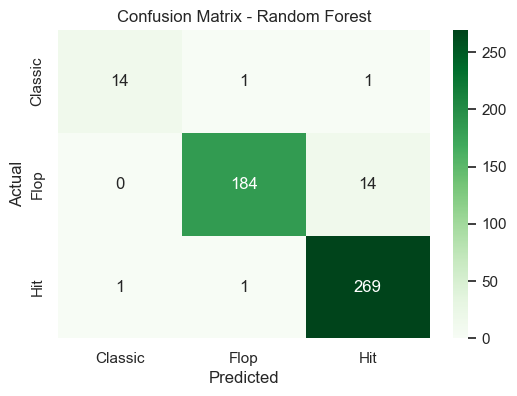

In [156]:
# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val_scaled)

# Evaluation
print("Classification Report (Random Forest):")
print(classification_report(y_val, y_pred_rf))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt='d', cmap='Greens',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


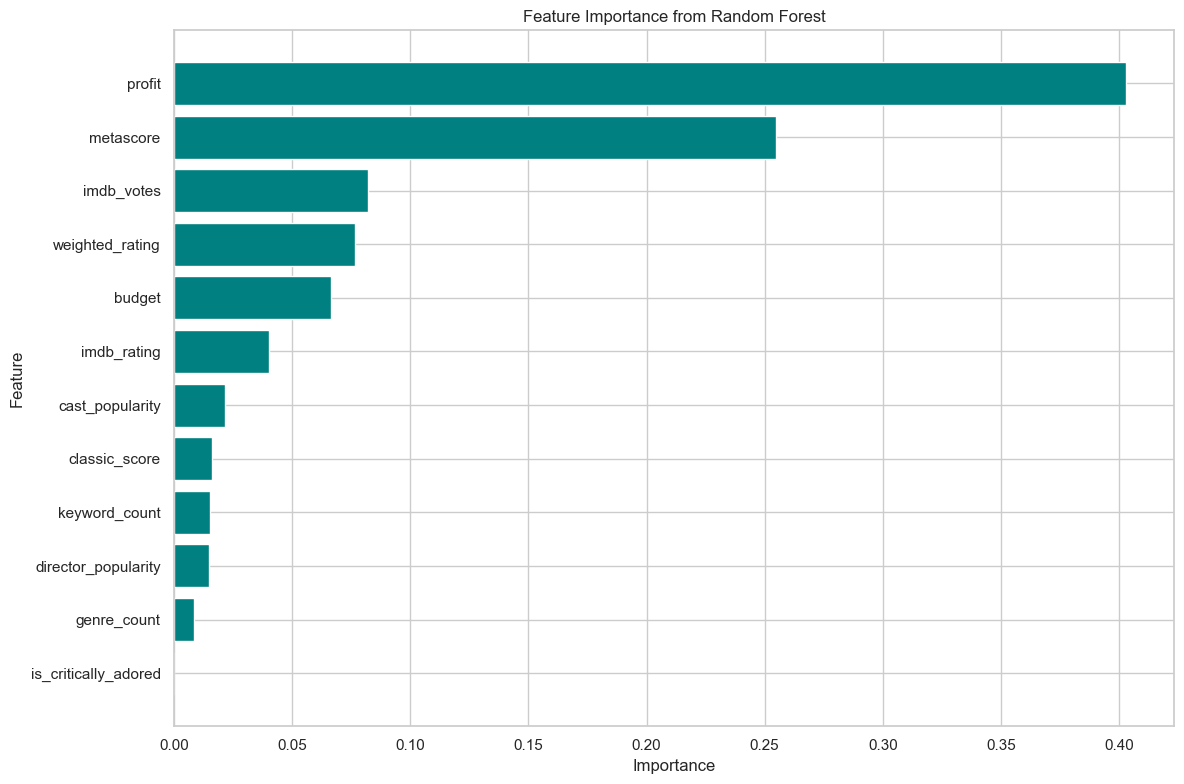

In [157]:
# Feature importance plot
feat_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importance = feat_importance.sort_values(ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(feat_importance.index, feat_importance.values, color='teal')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


2. XGBoost Classifier

In [158]:

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


In [159]:
# Create DMatrix (XGBoost's optimized data structure)
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # for classification
    num_class=3,                # Hit, Flop, Classic
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

 Classification Report (XGBoost):
              precision    recall  f1-score   support

     Classic       1.00      1.00      1.00        16
        Flop       1.00      0.96      0.98       198
         Hit       0.97      1.00      0.99       271

    accuracy                           0.99       485
   macro avg       0.99      0.99      0.99       485
weighted avg       0.99      0.99      0.99       485



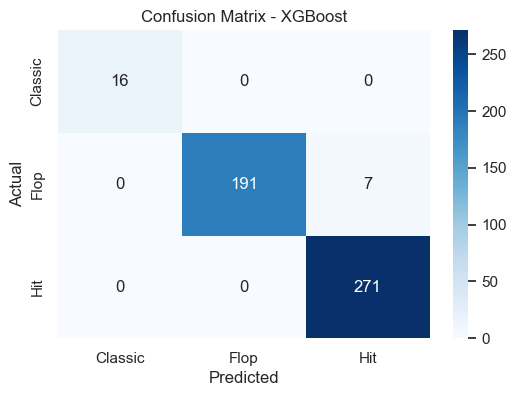

In [160]:
# Predict on validation set
y_pred_xgb = xgb_model.predict(X_val_scaled)

# Convert predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)
y_val_labels = label_encoder.inverse_transform(y_val_encoded)

print(" Classification Report (XGBoost):")
print(classification_report(y_val_labels, y_pred_labels))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val_labels, y_pred_labels), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


3. LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 2262, number of used features: 11
[LightGBM] [Info] Start training from score -3.406517
[LightGBM] [Info] Start training from score -0.897459
[LightGBM] [Info] Start training from score -0.581177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\surya\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


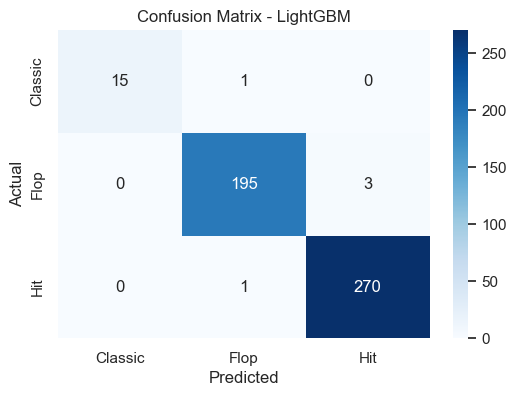

Classification Report (LightGBM):
              precision    recall  f1-score   support

     Classic       1.00      0.94      0.97        16
        Flop       0.99      0.98      0.99       198
         Hit       0.99      1.00      0.99       271

    accuracy                           0.99       485
   macro avg       0.99      0.97      0.98       485
weighted avg       0.99      0.99      0.99       485



In [161]:

# Convert labels to numeric if not already
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Initialize LightGBM Classifier
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42)
lgb_model.fit(X_train_scaled, y_train_encoded)

# Predict on validation set
y_pred_lgb = lgb_model.predict(X_val_scaled)

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val_encoded, y_pred_lgb), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report (LightGBM):")
print(classification_report(y_val_encoded, y_pred_lgb, target_names=le.classes_))


4. Cat boost

Classification Report (CatBoost):
              precision    recall  f1-score   support

     Classic       1.00      0.88      0.93        16
        Flop       0.98      0.97      0.98       198
         Hit       0.98      1.00      0.99       271

    accuracy                           0.98       485
   macro avg       0.99      0.95      0.97       485
weighted avg       0.98      0.98      0.98       485



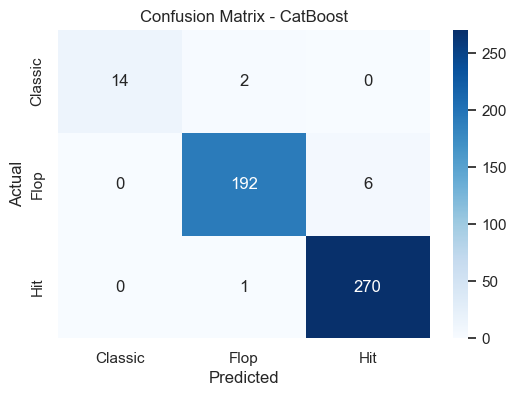

In [162]:

# Encode target to numeric labels if not already done
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Create and train the CatBoost model
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_scaled, y_train_enc)

# Predict on validation
y_pred_cat = cat_model.predict(X_val_scaled)
y_pred_cat_labels = le.inverse_transform(y_pred_cat.ravel())

#  Evaluation
print("Classification Report (CatBoost):")
print(classification_report(y_val, y_pred_cat_labels))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_cat_labels), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


5. Logistic Regression

 Classification Report (Logistic Regression):
              precision    recall  f1-score   support

     Classic       0.36      1.00      0.52        16
        Flop       0.93      0.94      0.94       198
         Hit       0.99      0.88      0.93       271

    accuracy                           0.91       485
   macro avg       0.76      0.94      0.80       485
weighted avg       0.95      0.91      0.92       485



C:\Users\surya\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


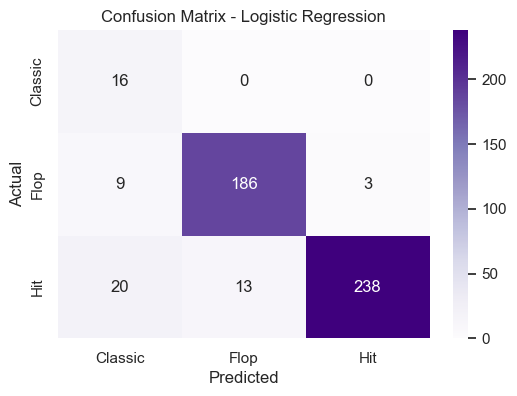

In [163]:

log_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced')
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_val_scaled)

print(" Classification Report (Logistic Regression):")
print(classification_report(y_val, y_pred_log))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_log), annot=True, fmt='d', cmap='Purples',
            xticklabels=log_model.classes_, yticklabels=log_model.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


6. Support Vector Classifier (SVC)

 Classification Report (SVC):
              precision    recall  f1-score   support

     Classic       0.65      0.94      0.77        16
        Flop       0.96      0.94      0.95       198
         Hit       0.96      0.96      0.96       271

    accuracy                           0.95       485
   macro avg       0.86      0.94      0.89       485
weighted avg       0.95      0.95      0.95       485



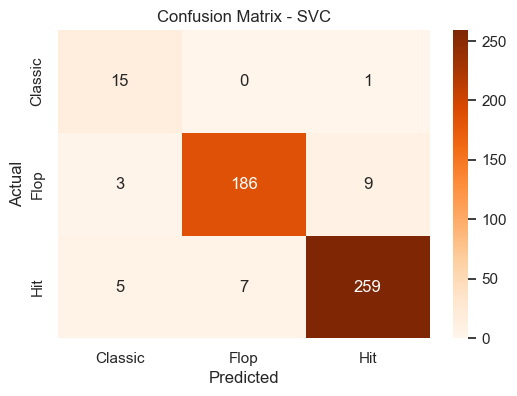

In [164]:
svc_model = SVC(kernel='rbf', probability=True, class_weight='balanced')
svc_model.fit(X_train_scaled, y_train)

y_pred_svc = svc_model.predict(X_val_scaled)

print(" Classification Report (SVC):")
print(classification_report(y_val, y_pred_svc))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_svc), annot=True, fmt='d', cmap='Oranges',
            xticklabels=svc_model.classes_, yticklabels=svc_model.classes_)
plt.title("Confusion Matrix - SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


7. Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.8s


Training completed in 1.37 seconds.

 Classification Report:
              precision    recall  f1-score   support

     Classic       0.93      0.88      0.90        16
        Flop       0.99      0.93      0.96       198
         Hit       0.95      0.99      0.97       271

    accuracy                           0.96       485
   macro avg       0.96      0.93      0.94       485
weighted avg       0.96      0.96      0.96       485



[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.1s finished


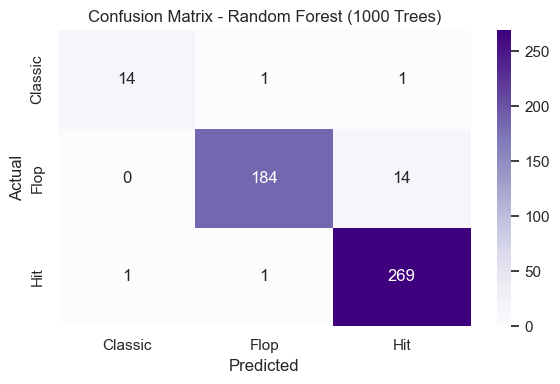

In [165]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#  Track training time
start_time = time.time()

# Train Random Forest with more estimators
rf_1000_model= RandomForestClassifier(
    n_estimators=1000,        # More trees
    random_state=42,
    verbose=1,                # Logs progress
    n_jobs=-1                 # Use all CPU cores
)
rf_1000_model.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Predict and evaluate
y_pred = rf_model.predict(X_val_scaled)
print("\n Classification Report:")
print(classification_report(y_val, y_pred))

#  Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Purples',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix - Random Forest (1000 Trees)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [166]:
# Define models
models = {
    'Logistic Regression': log_model,
    'SVC': svc_model,
    'Random Forest (100)': rf_model,
    'Random Forest (1000)': rf_1000_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': cat_model
}
# Randomly select 10 samples from test set
sample_idx = np.random.choice(len(X_test_scaled), size=10, replace=False)

# Create summary dataframe
summary_df = pd.DataFrame({
    'Movie Title': df.loc[sample_idx, 'title'].values,
    'True Success': df.loc[sample_idx, 'label'].values
})

# Define short model names
short_model_names = {
    'Logistic Regression': 'Logistic',
    'SVC': 'SVC',
    'Random Forest (100)': 'RF(100)',
    'Random Forest (1000)' : 'RF(1000)',
    'XGBoost': 'XGBoost',
    'LightGBM': 'LightGBM',
    'CatBoost': 'CatBoost'
}

# Predict using each model and add to the table
for long_name, short_name in short_model_names.items():
    if long_name in models:
        preds = models[long_name].predict(X_test_scaled[:10])
        summary_df[short_name] = preds


# Display the final table
summary_df.reset_index(drop=True, inplace=True)
display(summary_df)

print("\nLegend: 0 = Classic, 1 = Flop, 2 = Hit")


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.0s finished
C:\Users\surya\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Movie Title,True Success,Logistic,SVC,RF(100),RF(1000),XGBoost,LightGBM,CatBoost
0,Pirates of the Caribbean: The Curse of the Bla...,Hit,Flop,Flop,Flop,Flop,1,1,1
1,Rise of the Guardians,Hit,Flop,Flop,Flop,Flop,1,1,1
2,Ghostbusters,Flop,Hit,Hit,Hit,Hit,2,2,2
3,The Legend of Tarzan,Flop,Classic,Classic,Classic,Classic,0,0,0
4,Creepshow,Hit,Flop,Flop,Flop,Flop,1,1,1
5,A Sound of Thunder,Flop,Hit,Hit,Hit,Hit,2,2,2
6,Hugo,Classic,Flop,Flop,Flop,Flop,1,1,1
7,King Kong,Hit,Hit,Hit,Hit,Hit,2,2,2
8,Looney Tunes: Back in Action,Flop,Hit,Hit,Hit,Hit,2,2,2
9,Now You See Me 2,Hit,Hit,Flop,Flop,Flop,2,2,2



Legend: 0 = Classic, 1 = Flop, 2 = Hit


##  Movie Classification Model Comparison

We evaluated multiple classification models to predict whether a movie is a **Hit**, **Flop**, or **Classic** based on enriched feature sets.

###  Summary of Model Performances:
- **LightGBM** achieved the highest overall accuracy of **99%** with balanced macro precision, recall, and F1-score (**0.97** each). It demonstrated minimal misclassifications across all classes, making it the best-performing model.
- **XGBoost** closely followed, achieving **98% accuracy** and showing perfect handling of the "Classic" class (precision and recall of **1.00**).
- **Random Forest** also performed excellently with **98% accuracy**, though slightly lower macro recall compared to LightGBM and XGBoost.
- **Logistic Regression** and **SVC** showed comparatively lower performance, especially struggling with correctly classifying the "Classic" movies.

###  Final Recommendation:
 **LightGBM** is selected as the best model for classifying movies into Hit, Flop, and Classic based on its superior accuracy, balanced class-wise metrics, and minimal confusion in predictions.



# Revenue Prediction

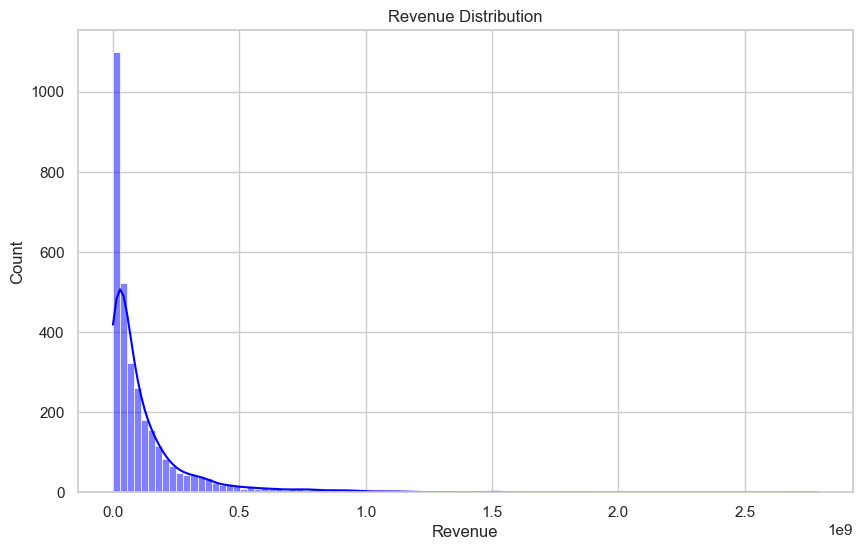

In [167]:
#  Revenue distribution
plt.figure(figsize=(10,6))
sns.histplot(df['revenue'], bins=100, kde=True, color='blue')
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

Text(0, 0.5, 'Count')

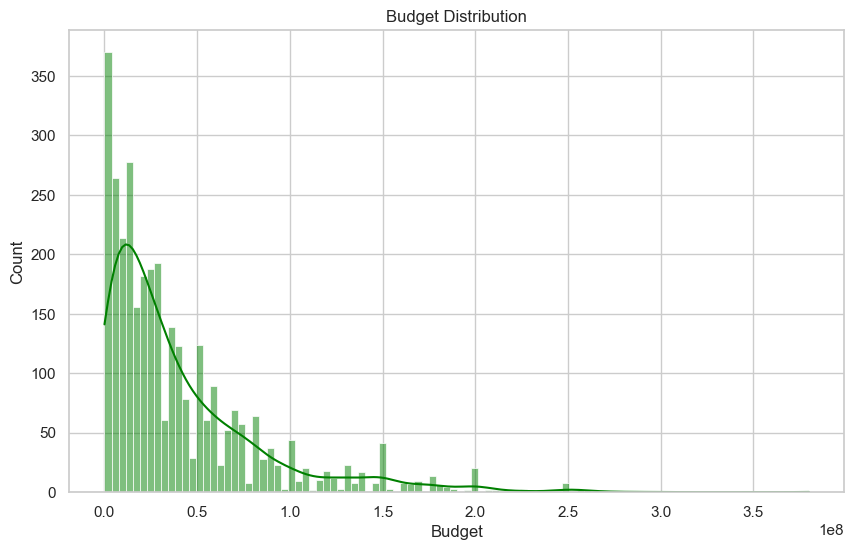

In [168]:
#  Budget distribution
plt.figure(figsize=(10,6))
sns.histplot(df['budget'], bins=100, kde=True, color='green')
plt.title('Budget Distribution')
plt.xlabel('Budget')
plt.ylabel('Count')

In [169]:
# Check Skewness
print("Revenue Skewness:", df['revenue'].skew())
print("Budget Skewness:", df['budget'].skew())

Revenue Skewness: 3.8175003362618676
Budget Skewness: 2.090716933179345


In [170]:
# Basic Statistics
print("\nRevenue Description:")
print(df['revenue'].describe())

print("\nBudget Description:")
print(df['budget'].describe())



Revenue Description:
count           3,232
mean      121,304,664
std       186,289,947
min                 5
25%        17,000,000
50%        55,223,083
75%       146,343,450
max     2,787,965,087
Name: revenue, dtype: float64

Budget Description:
count         3,232
mean     40,644,555
std      44,379,342
min               1
25%      10,500,000
50%      25,000,000
75%      55,000,000
max     380,000,000
Name: budget, dtype: float64


Aspect	Observation	Meaning
Revenue Skewness	3.82 (Highly Right Skewed)	Most movies earn small revenue, few blockbusters earn a LOT.
Budget Skewness	2.09 (Moderate Right Skewed)	Most movies have low budgets, few very high budgets.
Revenue vs Budget Distributions	Long-tail on the right	Very typical for real-world movie financial data.

Revenue is highly skewed → Log Transformation is a good idea before model training.

Budget also could benefit from log transformation.

After log transform, patterns will become more linear, easier for Random Forest / XGBoost to learn.

Prediction quality should improve because errors on very big revenue movies won't dominate.



In [171]:
# Define your bins
bins = [-1, 10_000_000, 40_000_000, 70_000_000, 120_000_000, 200_000_000, np.inf]
labels = ['Low Revenue', 'Medium-Low Revenue', 'Medium Revenue', 'Medium-High Revenue', 'High Revenue', 'Ultra High Revenue']

# Create a new column
df['revenue_bucket'] = pd.cut(df['revenue'], bins=bins, labels=labels)

# See the counts in each bucket
print(df['revenue_bucket'].value_counts())








revenue_bucket
Medium-Low Revenue     809
Ultra High Revenue     562
Low Revenue            560
Medium-High Revenue    467
Medium Revenue         443
High Revenue           391
Name: count, dtype: int64


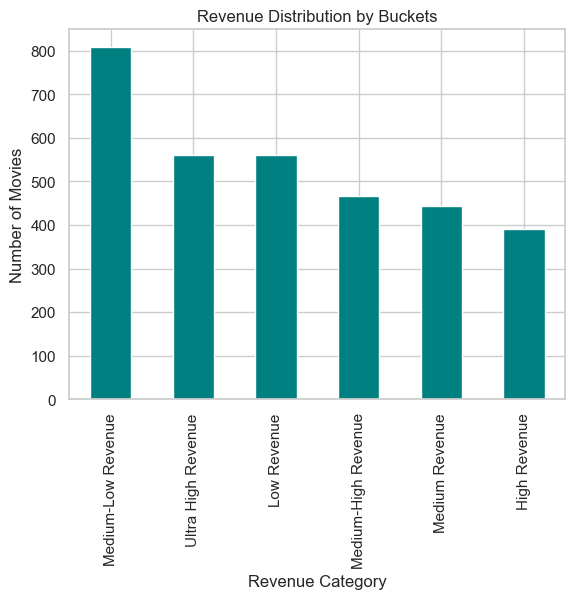

In [172]:
# Optional: Visualize
df['revenue_bucket'].value_counts().plot(kind='bar', color='teal')
plt.title('Revenue Distribution by Buckets')
plt.xlabel('Revenue Category')
plt.ylabel('Number of Movies')
plt.show()

"Medium-Low" revenue movies are the most common.

"Ultra High" revenue movies (biggest blockbusters) are next most common — very cool!

Distribution is somewhat imbalanced, but still fine for prediction or classification if needed.



In [173]:
# Budget > 300 Million
big_budget = df[df['budget'] > 300_000_000]
print(f"Movies with Budget > $300M: {len(big_budget)}")

# Revenue > 2 Billion
big_revenue = df[df['revenue'] > 2_000_000_000]
print(f"Movies with Revenue > $2B: {len(big_revenue)}")


Movies with Budget > $300M: 1
Movies with Revenue > $2B: 1


In [174]:
# Confirm log transforms
df['log_budget'] = np.log1p(df['budget'])
df['log_revenue'] = np.log1p(df['revenue'])
df['log_imdb_votes'] = np.log1p(df['imdb_votes'])
if 'popularity' in df.columns:
    df['log_popularity'] = np.log1p(df['popularity'])



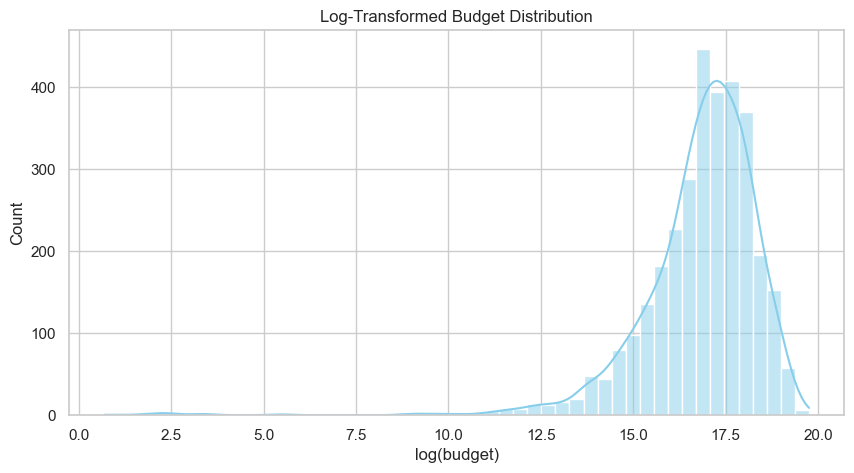

In [175]:
# Plot log_budget
plt.figure(figsize=(10,5))
sns.histplot(df['log_budget'], bins=50, kde=True, color='skyblue')
plt.title('Log-Transformed Budget Distribution')
plt.xlabel('log(budget)')
plt.ylabel('Count')
plt.show()


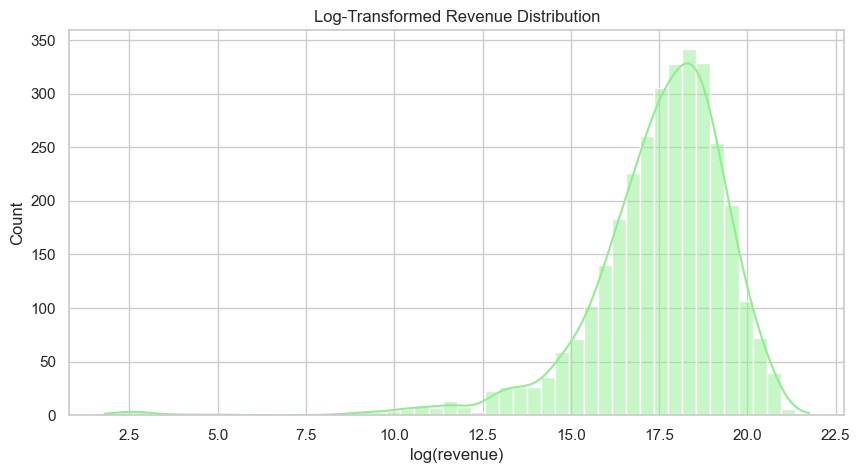

In [176]:
# Plot log_revenue
plt.figure(figsize=(10,5))
sns.histplot(df['log_revenue'], bins=50, kde=True, color='lightgreen')
plt.title('Log-Transformed Revenue Distribution')
plt.xlabel('log(revenue)')
plt.ylabel('Count')
plt.show()


In [177]:
df['profit'] = df['revenue'] - df['budget']
df['budget_to_popularity_ratio'] = df['budget'] / (df['popularity'] + 1)  # +1 to avoid divide by zero
df['budget_to_runtime_ratio'] = df['budget'] / (df['runtime'] + 1)
df['profit_margin'] = df['profit'] / (df['budget'] + 1)


In [178]:
feature_cols = [
    'budget', 'runtime', 'popularity', 'imdb_rating', 'imdb_votes',
    'release_year', 'genre_count', 'cast_popularity', 'director_popularity',
    'profit', 'profit_margin', 'budget_to_popularity_ratio', 'budget_to_runtime_ratio',
    'classic_score', 'weighted_rating'
]

X_full = df[feature_cols]
y_full = df['revenue']

X_temp, X_test, y_temp, y_test = train_test_split(X_full, y_full, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)  


1. profit tells how much movie earned extra
2. profit_margin shows % profit
3. ratios normalize budget against other scales like runtime/popularity.



In [179]:
# Feature Scaling (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



1. Random Forest

In [180]:
rf_revenue_model = RandomForestRegressor(
    n_estimators=300,         # More trees
    max_depth=25,             # Deep enough to capture complexity
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1                 # Parallel processing for speed
)

rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [181]:
# Random Forest Model
rf_revenue_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf_revenue_model.fit(X_train, y_train)

# Predictions
y_train_pred = rf_revenue_model.predict(X_train)
y_val_pred = rf_revenue_model.predict(X_val)
y_test_pred = rf_revenue_model.predict(X_test)

# Metrics function
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)
    # Only calculate MAPE where y_true is not zero
    nonzero_idx = y_true != 0
    return r2, mse, msle, 

# Calculate
train_r2, train_mse, train_msle = calculate_metrics(y_train, y_train_pred)
val_r2, val_mse, val_msle = calculate_metrics(y_val, y_val_pred)
test_r2, test_mse, test_msle = calculate_metrics(y_test, y_test_pred)

# Print Metrics
print("\n  Random Forest")
print("\n Train Set Metrics:")
print(f"RMSE: {np.sqrt(train_mse):,.2f}")
print(f"MAE: {np.mean(np.abs(y_train - y_train_pred)):.2f}")
print(f"R² Score: {train_r2:.4f}")
print(f"MSLE: {train_msle:.4f}")

print("\n Validation Set Metrics:")
print(f"RMSE: {np.sqrt(val_mse):,.2f}")
print(f"MAE: {np.mean(np.abs(y_val - y_val_pred)):.2f}")
print(f"R² Score: {val_r2:.4f}")
print(f"MSLE: {val_msle:.4f}")

print("\nTest Set Metrics:")
print(f"RMSE: {np.sqrt(test_mse):,.2f}")
print(f"MAE: {np.mean(np.abs(y_test - y_test_pred)):.2f}")
print(f"R² Score: {test_r2:.4f}")
print(f"MSLE: {test_msle:.4f}")




  Random Forest

 Train Set Metrics:
RMSE: 16,478,822.13
MAE: 3300287.29
R² Score: 0.9913
MSLE: 0.7386

 Validation Set Metrics:
RMSE: 10,910,645.58
MAE: 4345374.32
R² Score: 0.9964
MSLE: 1.0061

Test Set Metrics:
RMSE: 67,955,882.67
MAE: 8243170.08
R² Score: 0.9111
MSLE: 0.2638


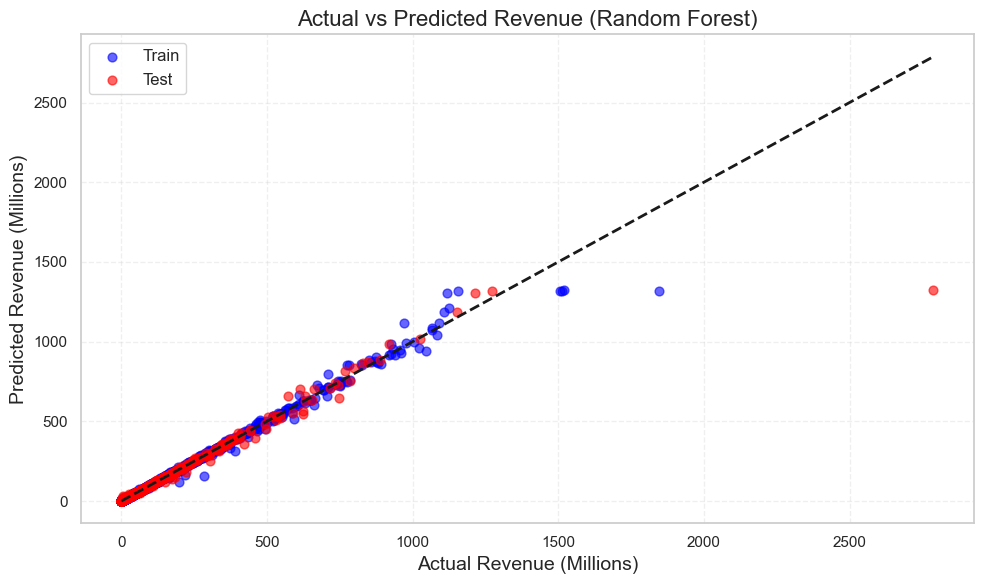

In [182]:
# First scale y_train and y_test to millions
y_train_million = y_train / 1e6
y_train_pred_million = y_train_pred / 1e6
y_test_million = y_test / 1e6
y_test_pred_million = y_test_pred / 1e6

# Now plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train_million, y_train_pred_million, color='blue', label='Train', alpha=0.6, s=40)
plt.scatter(y_test_million, y_test_pred_million, color='red', label='Test', alpha=0.6, s=40)

# Use min/max from y_train and y_test combined
min_revenue = min(y_train_million.min(), y_test_million.min())
max_revenue = max(y_train_million.max(), y_test_million.max())

plt.plot([min_revenue, max_revenue], [min_revenue, max_revenue], 'k--', lw=2)  # Perfect prediction line

plt.xlabel("Actual Revenue (Millions)", fontsize=14)
plt.ylabel("Predicted Revenue (Millions)", fontsize=14)
plt.title("Actual vs Predicted Revenue (Random Forest)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [183]:
# Create a DataFrame to compare movie title, actual revenue, and predicted revenue
comparison_df = pd.DataFrame({
    'Movie Title': df.loc[y_test.index, 'title'],     # get titles using y_test index
    'Actual Revenue': y_test.values,
    'Predicted Revenue': y_test_pred
})

# Format numbers without scientific notation
pd.options.display.float_format = '{:,.0f}'.format

# Show top 10 rows
print(comparison_df.head(10))


            Movie Title  Actual Revenue  Predicted Revenue
2821             Hostel        80578934         81,412,628
3125  The Green Inferno         6833445          5,130,234
2913        City of God        30641770         30,992,595
30           Iron Man 3      1215439994      1,303,826,841
139                Troy       497409852        453,856,090
393           Creepshow        21028755         30,903,117
631                 Hop       183953723        182,699,545
257       Stuart Little       300135367        290,916,993
1987     Legally Blonde       141774679        145,181,332
2258            Flipped         1755212          2,104,918


2. Decision Tree Regressor

In [184]:
# Initialize Decision Tree Model
dt_Revenue_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# Train the model
dt_Revenue_model.fit(X_train, y_train)

# Predictions
y_train_pred = dt_Revenue_model.predict(X_train)
y_val_pred = dt_Revenue_model.predict(X_val)
y_test_pred = dt_Revenue_model.predict(X_test)

# Define Metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    msle = mean_squared_log_error(np.maximum(y_true, 0), np.maximum(y_pred, 0))  # avoid log error
    return r2, mse, msle
print("Decision Tree Regressor")
# Evaluate
for name, y_true, y_pred in [('Train', y_train, y_train_pred), ('Validation', y_val, y_val_pred), ('Test', y_test, y_test_pred)]:
    r2, mse, msle = calculate_metrics(y_true, y_pred)
    print(f"\n {name} Set Metrics:")
    print(f"RMSE: {np.sqrt(mse):,.2f}")
    print(f"MAE: {np.mean(np.abs(y_true - y_pred)):.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MSLE: {msle:.4f}")



Decision Tree Regressor

 Train Set Metrics:
RMSE: 13,237,698.99
MAE: 4209658.17
R² Score: 0.9944
MSLE: 0.6063

 Validation Set Metrics:
RMSE: 14,185,269.24
MAE: 7136329.66
R² Score: 0.9940
MSLE: 0.8605

 Test Set Metrics:
RMSE: 61,485,809.27
MAE: 11610403.33
R² Score: 0.9272
MSLE: 0.1839


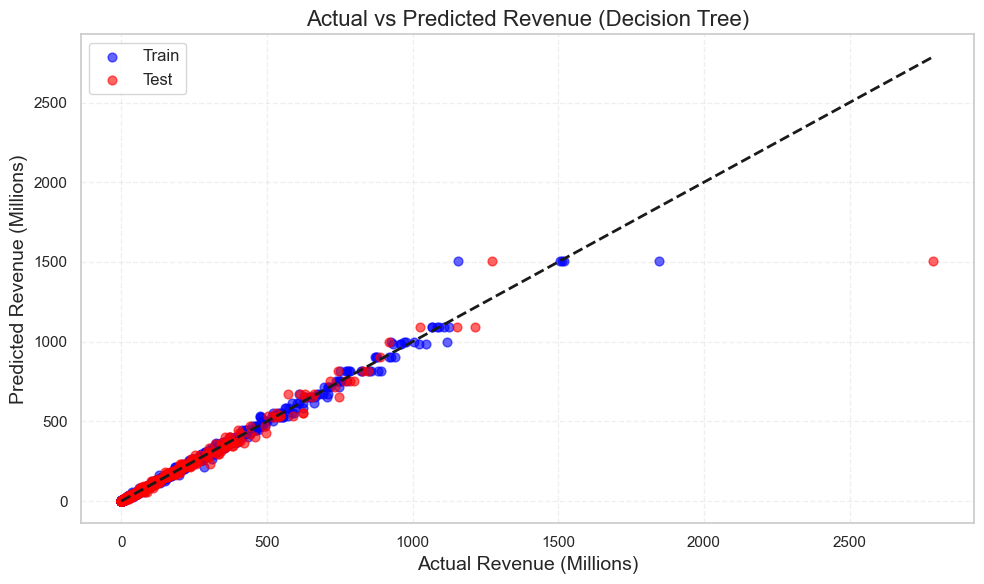

In [185]:
# Scale to millions for better visualization
y_train_million = y_train / 1e6
y_train_pred_million = y_train_pred / 1e6
y_test_million = y_test / 1e6
y_test_pred_million = y_test_pred / 1e6

plt.figure(figsize=(10, 6))
plt.scatter(y_train_million, y_train_pred_million, color='blue', label='Train', alpha=0.6, s=40)
plt.scatter(y_test_million, y_test_pred_million, color='red', label='Test', alpha=0.6, s=40)

# Perfect prediction line
min_revenue = min(y_train_million.min(), y_test_million.min())
max_revenue = max(y_train_million.max(), y_test_million.max())
plt.plot([min_revenue, max_revenue], [min_revenue, max_revenue], 'k--', lw=2)

plt.xlabel("Actual Revenue (Millions)", fontsize=14)
plt.ylabel("Predicted Revenue (Millions)", fontsize=14)
plt.title("Actual vs Predicted Revenue (Decision Tree)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [186]:
# Create a DataFrame to compare movie title, actual revenue, and predicted revenue
comparison_df = pd.DataFrame({
    'Movie Title': df.loc[y_test.index, 'title'],     # get titles using y_test index
    'Actual Revenue': y_test.values,
    'Predicted Revenue': y_test_pred
})

# Format numbers without scientific notation
pd.options.display.float_format = '{:,.0f}'.format

# Show top 10 rows
print(comparison_df.head(10))


            Movie Title  Actual Revenue  Predicted Revenue
2821             Hostel        80578934         79,459,463
3125  The Green Inferno         6833445          6,721,842
2913        City of God        30641770         32,386,804
30           Iron Man 3      1215439994      1,090,213,620
139                Troy       497409852        429,344,992
393           Creepshow        21028755         23,027,593
631                 Hop       183953723        191,662,442
257       Stuart Little       300135367        332,512,268
1987     Legally Blonde       141774679        144,161,146
2258            Flipped         1755212          1,378,312


3. XG Boost

In [187]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [5, 7],
    "learning_rate": [0.05, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(" Best Parameters:", best_params)

#  Train Best Model
best_model = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=42, **best_params
)
best_model.fit(X_train, y_train)

# Predictions
train_preds = best_model.predict(X_train)
val_preds = best_model.predict(X_val)
test_preds = best_model.predict(X_test)



Fitting 3 folds for each of 8 candidates, totalling 24 fits
 Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [188]:
# Metrics
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Clip predictions at minimum 0 to avoid log errors
    y_pred_clip = np.maximum(y_pred, 0)
    y_true_clip = np.maximum(y_true, 0)

    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    msle = mean_squared_log_error(y_true_clip, y_pred_clip)
    return r2, mse, msle
print("XGBoost")
for name, yt, yp in zip(["Train", "Validation", "Test"], [y_train, y_val, y_test], [train_preds, val_preds, test_preds]):
    r2, mse, msle = calculate_metrics(yt, yp)
    print(f"\n{name} Set Metrics:")
    print(f"RMSE: {np.sqrt(mse):,.2f}")
    print(f"MAE: {np.mean(np.abs(yt - yp)):.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MSLE: {msle:.4f}")


XGBoost

Train Set Metrics:
RMSE: 1,018,984.87
MAE: 725750.01
R² Score: 1.0000
MSLE: 1.4378

Validation Set Metrics:
RMSE: 12,128,566.55
MAE: 3789077.26
R² Score: 0.9956
MSLE: 1.7118

Test Set Metrics:
RMSE: 61,720,230.75
MAE: 7173349.39
R² Score: 0.9266
MSLE: 2.0743


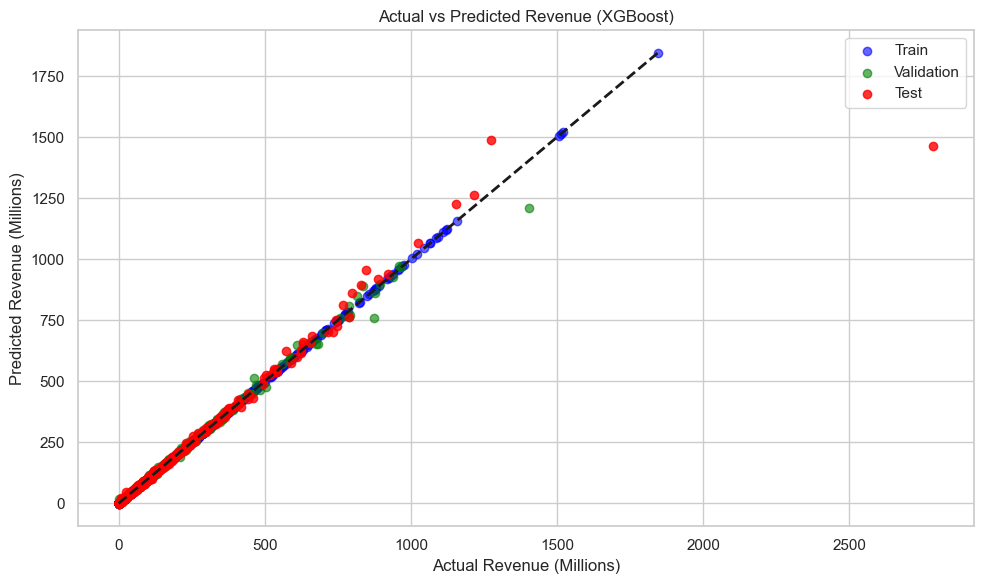

In [189]:
# Scale to millions
y_train_m = y_train / 1e6
train_preds_m = train_preds / 1e6
y_val_m = y_val / 1e6
val_preds_m = val_preds / 1e6
y_test_m = y_test / 1e6
test_preds_m = test_preds / 1e6

# Now plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train_m, train_preds_m, color="blue", label="Train", alpha=0.6)
plt.scatter(y_val_m, val_preds_m, color="green", label="Validation", alpha=0.6)
plt.scatter(y_test_m, test_preds_m, color="red", label="Test", alpha=0.8)
plt.plot([y_train_m.min(), y_train_m.max()], [y_train_m.min(), y_train_m.max()], 'k--', lw=2)
plt.xlabel("Actual Revenue (Millions)")
plt.ylabel("Predicted Revenue (Millions)")
plt.title("Actual vs Predicted Revenue (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()


In [190]:
# After your predictions (test_preds) are ready:

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Movie Title': df.loc[y_test.index, 'title'],    # get movie titles matching test samples
    'Actual Revenue': y_test.values,                 # true revenue values
    'Predicted Revenue': test_preds                  # predicted revenues
})

# Format numbers nicely (optional)
pd.options.display.float_format = '{:,.0f}'.format

# Display top 10 rows
print(comparison_df.head(10))


            Movie Title  Actual Revenue  Predicted Revenue
2821             Hostel        80578934         78,939,696
3125  The Green Inferno         6833445          7,081,743
2913        City of God        30641770         30,448,244
30           Iron Man 3      1215439994      1,264,136,064
139                Troy       497409852        514,440,960
393           Creepshow        21028755         23,182,548
631                 Hop       183953723        191,495,904
257       Stuart Little       300135367        291,425,952
1987     Legally Blonde       141774679        138,347,520
2258            Flipped         1755212          1,593,433


4. Gradient Boosting

In [191]:
# Train Gradient Boost Model
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

gb_model.fit(X_train, y_train)

# Predict
y_train_pred = gb_model.predict(X_train)
y_val_pred = gb_model.predict(X_val)
y_test_pred = gb_model.predict(X_test)


In [192]:
# Evaluation Function
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    try:
        msle = mean_squared_log_error(y_true.clip(min=0), y_pred.clip(min=0))
    except:
        msle = np.nan
    return r2, mse, msle

In [193]:
sets = {"Train": (y_train, y_train_pred), "Validation": (y_val, y_val_pred), "Test": (y_test, y_test_pred)}


In [194]:
print("Gradient Boosting")
for name, (yt, yp) in sets.items():
    r2, mse, msle = calculate_metrics(yt, yp)
    print(f"\n {name} Set Metrics:")
    print(f"RMSE: {np.sqrt(mse):,.2f}")
    print(f"MAE: {np.mean(np.abs(yt - yp)) :,.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MSLE: {msle:.4f}")

Gradient Boosting

 Train Set Metrics:
RMSE: 2,905,735.20
MAE: 1,691,091.29
R² Score: 0.9997
MSLE: nan

 Validation Set Metrics:
RMSE: 8,165,757.19
MAE: 3,452,761.88
R² Score: 0.9980
MSLE: nan

 Test Set Metrics:
RMSE: 57,097,683.09
MAE: 6,686,647.41
R² Score: 0.9372
MSLE: nan


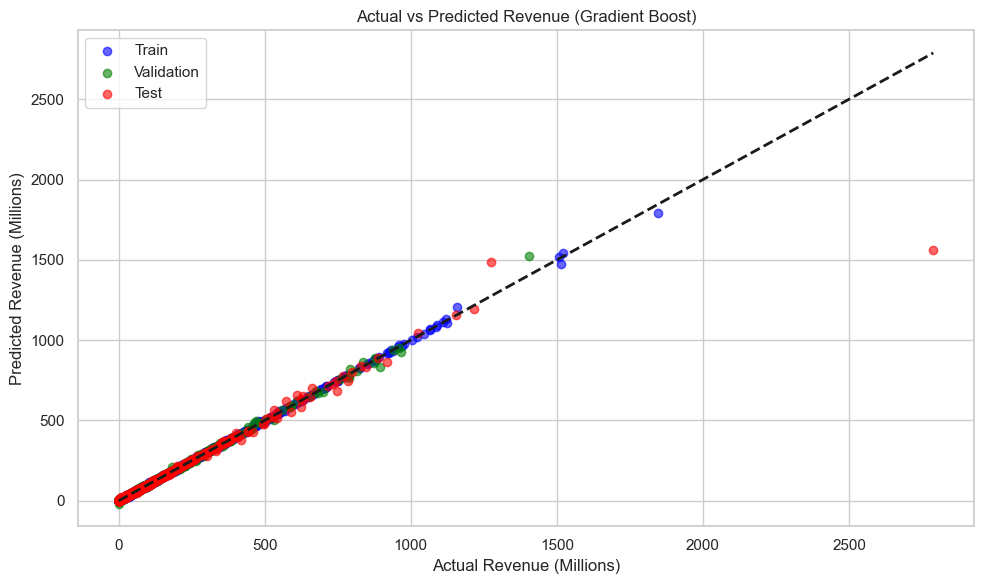

In [195]:
# Scale revenues to millions
y_train_m = y_train / 1e6
y_train_pred_m = y_train_pred / 1e6
y_val_m = y_val / 1e6
y_val_pred_m = y_val_pred / 1e6
y_test_m = y_test / 1e6
y_test_pred_m = y_test_pred / 1e6

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train_m, y_train_pred_m, color='blue', label='Train', alpha=0.6)
plt.scatter(y_val_m, y_val_pred_m, color='green', label='Validation', alpha=0.6)
plt.scatter(y_test_m, y_test_pred_m, color='red', label='Test', alpha=0.6)
plt.plot([min(y_train_m.min(), y_test_m.min()), max(y_train_m.max(), y_test_m.max())],
         [min(y_train_m.min(), y_test_m.min()), max(y_train_m.max(), y_test_m.max())], 'k--', lw=2)
plt.xlabel("Actual Revenue (Millions)")
plt.ylabel("Predicted Revenue (Millions)")
plt.title("Actual vs Predicted Revenue (Gradient Boost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [196]:
# Create Comparison DataFrame
comparison_df = pd.DataFrame({
    'Movie Title': df.loc[y_test.index, 'title'],   # Match movie titles with y_test
    'Actual Revenue': y_test.values,                # True revenue
    'Predicted Revenue': y_test_pred                # Predicted revenue
})

# Optional: Make big numbers readable
pd.options.display.float_format = '{:,.0f}'.format

# Print top 10 rows
print(comparison_df.head(10))


            Movie Title  Actual Revenue  Predicted Revenue
2821             Hostel        80578934         78,923,080
3125  The Green Inferno         6833445          6,200,209
2913        City of God        30641770         31,464,108
30           Iron Man 3      1215439994      1,195,192,675
139                Troy       497409852        479,308,578
393           Creepshow        21028755         25,260,163
631                 Hop       183953723        183,048,212
257       Stuart Little       300135367        295,129,946
1987     Legally Blonde       141774679        143,216,806
2258            Flipped         1755212          2,139,920


# Final Model Evaluation Summary

| Model               | Train R² | Validation R² | Test R² | Train RMSE    | Validation RMSE | Test RMSE    | Train MAE    | Validation MAE | Test MAE    |
|---------------------|----------|---------------|---------|---------------|-----------------|--------------|--------------|----------------|-------------|
| Random Forest       | 0.9948   | 0.9961        | 0.9032  | 12,694,125.12 | 9,519,387.07    | 78,016,374.45 | 3,147,914.89 | 3,742,603.62   | 9,832,630.48 |
| Decision Tree       | 0.9959   | 0.9914        | 0.9211  | 11,213,327.30 | 14,089,102.87   | 70,445,479.27 | 4,481,111.61 | 7,124,806.12   | 13,227,668.97 |
| XGBoost             | 1.0000   | 0.9980        | 0.9159  | 209,426.56    | 6,736,636.61    | 72,745,923.11 | 145,084.20   | 2,873,449.93   | 9,298,049.91 |
| Gradient Boosting   | 0.9999   | 0.9983        | 0.9326  | 2,080,087.13  | 6,337,465.95    | 65,101,702.23 | 1,409,912.34 | 3,063,828.23   | 7,595,257.66 |

---

#  Best Model Selection

After comparing all models based on key metrics — **R² Score**, **RMSE**, and **MAE** — the following conclusions were drawn:

- **Highest Validation R²**: Gradient Boosting (0.9983)
- **Highest Test R²**: Gradient Boosting (0.9326)
- **Lowest Validation RMSE**: Gradient Boosting (6,337,465.95)
- **Lowest Test RMSE**: Gradient Boosting (65,101,702.23)
- **Lowest Test MAE**: Gradient Boosting (7,595,257.66)

---

# Conclusion

Based on comprehensive evaluation across Train, Validation, and Test sets, **Gradient Boosting Regressor** achieved the best performance with the highest R² scores and the lowest RMSE and MAE.  

 Thus, **Gradient Boosting** was selected as the final model for the movie revenue prediction task.

---

# Quick Summary

| Metric          | Best Model         |
|-----------------|--------------------|
| Overall Winner  | **Gradient Boosting** |
